In [1]:
import numpy as np
from FRCfuncs import *
import matplotlib.pyplot as plt
from scipy import special

## spot broadening for polar constrained linkers

Suppose we have a diffraction limited Gaussian spot of 40nm FWHM. Our object is a DNA strand of 14 nm with Donor at the glass surface and acceptor at the far end. The DNA strand has a fixed polar angle \theta with the glass surface and can freely diffuse in the azimuthal angle phi. Suppose the angle \theta is 30, the position of the dye is then fixed on a circle with radius 7nm.
We can describe the observed spot as a convolution between the PSF and the object function. The convolution is computed via multiplication in Fourier space. The FT of a Gauss is a Gauss. The FT of a cirkel is a zeroth order Besselfunction with argument 2\pi R \rho. Where R is the radius of the cirkel and \rho is the radial argument in Fourier space. (Derivation on paper) and here: https://www.eee.hku.hk/~work8501/WWW2008/ho2.pdf.

In [2]:
def OBJECT(rho):
    return special.j0(2 * np.pi * R * rho) #Applicable Bessel function from paper derivation

In [23]:
def ImageRing(sigma, R, box = 200, PSFFWHM = 40):
    """Convolves ring object with gaussian PSF. Ring object is calculated directly in Fourier Space
    using zero order Bessel """
    x = np.arange(box)
    y = np.arange(box)
    coord = np.meshgrid(x, y)
    rho_coord = np.sqrt((coord[0]-box/2)**2+(coord[1]-box/2)**2)/box #radial coordinate map centered around middle

    psf = twoD_Gaussian(coord, 1, box/2, box/2, sigma, sigma, 0, 0).reshape([box,box])
    OTF = np.fft.fftshift(np.fft.fft2(psf))
    OBJECT = special.j0(2 * np.pi * R * rho_coord)
    IMAGE = OTF * OBJECT #operation. note complex conjugate is not taken as OBJECT is already real.
    image = np.fft.ifft2(np.fft.fftshift(IMAGE))
    Object = np.fft.ifft2(OBJECT)
    p0 = [1, box/2, box/2, sigma, sigma, 0, 0]
    [_,_,_,sigma,*_], _ = curve_fit(twoD_Gaussian, coord, abs(image).ravel(), p0=p0)

    return sigma, image

In [28]:
PSFFWHM = 40
R = np.arange(30)
sigma = np.ones(30)
images = np.ones(30*200*200).reshape(30,200,200)
for i, el in enumerate(R):
    sigma[i], images[i] = ImageRing(PSFFWHM /2.355,el)

C:\Users\voort\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\voort\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  


At ring radius of 7 nm, the spot has enlarged to 32.3 nm, the spot of a point source is 30nm.


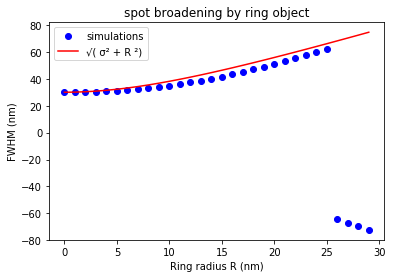

In [27]:
plt.plot(sigma*2.355, 'bo', label = 'simulations' )
plt.plot(np.sqrt((PSFFWHM /2.355)**2+R**2)*2.355, 'r',label = u'\u221A( \u03C3\u00B2 + R \u00B2)')
plt.legend()
plt.xlabel('Ring radius R (nm)')
plt.ylabel('FWHM (nm)')
plt.title('spot broadening by ring object')
plt.savefig('20190614BroadeningGraph.png', dpi = 300)
print('At ring radius of 7 nm, the spot has enlarged to %.1f nm, the spot of a point source is 30nm.'%(sigma[7]*2.355))

C:\Users\voort\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


FWHM of PSF is 40nm (input)
Ring structure with 14nm diameter has FWHM of 41.7 nm (2D gaussian fit)
Gauss object with FWHM of 16.5 generates spot of FWHM 43.3 (exact calculation)


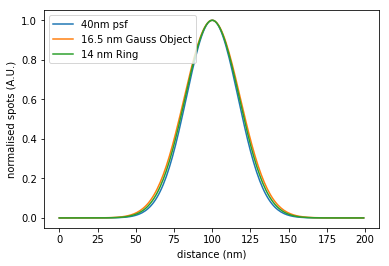

In [44]:
sigmaRing7nm, Ring7nm = ImageRing(40 /2.355,7)
box = 200
sigma = 40/2.355
x = np.arange(box)
y = np.arange(box)
coord = np.meshgrid(x, y)
psf = twoD_Gaussian(coord, 1, box/2, box/2, sigma, sigma, 0, 0).reshape([box,box])[100]
GaussBroadenedSigma = np.sqrt(sigma**2 + 7**2 )
GaussObject = twoD_Gaussian(coord, 1, box/2, box/2, GaussBroadenedSigma, GaussBroadenedSigma, 0, 0).reshape([box,box])[100]
plt.plot(psf, label = '40nm psf')
plt.plot(GaussObject, label = '16.5 nm Gauss Object')
plt.plot(abs(Ring7nm[100])/max(Ring7nm[100]), label = '14 nm Ring')
plt.legend()
plt.xlabel('distance (nm)')
plt.ylabel('normalised spots (A.U.)')
plt.savefig('20190614ObjectBroadening.png', dpi = 300)
print('FWHM of PSF is 40nm (input)')
print('Ring structure with 14nm diameter has FWHM of %.1f nm (2D gaussian fit)'%(sigmaRing7nm*2.355))
print('Gauss object with FWHM of %.1f generates spot of FWHM %.1f (exact calculation)'
      % (7*2.355, GaussBroadenedSigma*2.355))

In [203]:
def ImageGauss(sigma, R, box = 200):
    """Convolves gaussian object with gaussian PSF. R indicates sigma of Gaussian."""
    sigma = 40 /2.355 #FWHM to sigma
    box = 200
    x = np.arange(box)
    y = np.arange(box)
    coord = np.meshgrid(x, y)

    psf = twoD_Gaussian(coord, 1, box/2, box/2, sigma, sigma, 0, 0).reshape([box,box])
    OTF = np.fft.fftshift(np.fft.fft2(PSF))
    Object = twoD_Gaussian(coord, 1, box/2, box/2, R, R, 0, 0).reshape([box,box])
    OBJECT = np.fft.fftshift(np.fft.fft2(Object))
    IMAGE = OTF * OBJECT #operation. note complex conjugate is not taken as OBJECT is already real.
    image = np.fft.ifft2(np.fft.fftshift(IMAGE))
    Object = np.fft.ifft2(OBJECT)
    [_,_,_,sigma,*_], _ = curve_fit(twoD_Gaussian, coord, abs(image).ravel(), p0=p0)

    return sigma, image

In [34]:
R = np.arange(1,30)
sigma = np.ones(30)
for i, el in enumerate(R):
    sigma[i], _ = ImageGauss(40 /2.355,el)

plt.plot(sigma*2.355, 'bo', label = 'simulations' )
plt.plot(np.sqrt((40 /2.355)**2+R**2)*2.355, 'r',label = u'\u221A( \u03C3\u00B2 + R \u00B2)')
plt.legend()
plt.xlabel('Ring radius R (nm)')
plt.ylabel('FWHM (nm)')
plt.title('spot broadening by ring object')
print('At ring diameter of 7 nm, the spot has enlarged to %.1f nm, the spot of a point source is 40nm.'
      %(sigma[7]*2.355))

NameError: name 'ImageGauss' is not defined

In [162]:
p0 = 1, box/2, box/2, sigma, sigma, 0, 0
print(sigma)
popt, pcov = curve_fit(twoD_Gaussian, coord, abs(image).ravel(), p0=p0)
print(popt)

16.985138004246284
[ 3.21982550e-01  9.99990819e+01  9.99990819e+01  3.27207358e+01
  3.27207358e+01 -3.75613525e-08 -8.59059631e-03]


C:\Users\voort\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [178]:
sigma

17.722833076719205

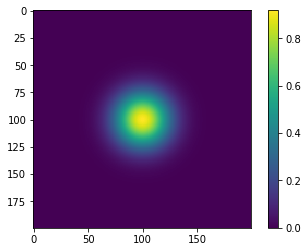

In [174]:
plt.imshow(np.abs(image))
plt.colorbar()